In [169]:
import neptune.new as neptune
run = neptune.init(project="XGBboost")

NeptuneMissingApiTokenException: 

----NeptuneMissingApiTokenException-------------------------------------------

Neptune client couldn't find your API token.

You can get it here:
    - https://app.neptune.ai/get_my_api_token

There are two options to add it:
    - specify it in your code
    - set an environment variable in your operating system.

CODE
Pass the token to neptune.init() via api_token argument:
    neptune.init(project='WORKSPACE_NAME/PROJECT_NAME', api_token='YOUR_API_TOKEN')

ENVIRONMENT VARIABLE (Recommended option)
or export or set an environment variable depending on your operating system:

    Linux/Unix
    In your terminal run:
        export NEPTUNE_API_TOKEN="YOUR_API_TOKEN"

    Windows
    In your CMD run:
        set NEPTUNE_API_TOKEN="YOUR_API_TOKEN"

and skip the api_token argument of neptune.init():
    neptune.init(project='WORKSPACE_NAME/PROJECT_NAME')

You may also want to check the following docs pages:
    - https://docs.neptune.ai/getting-started/installation#authentication-neptune-api-token

Need help?-> https://docs.neptune.ai/getting-started/getting-help


# 분석메모

- 요일별로 차이가 존재함  
- 이상치가 존재  
- 메뉴에 따라 차이가 있을까? (메인메뉴만 추출해서 사용해도 좋을 듯 하다)  
메뉴 부분은 어떻게 전처리를 해야할까?  
- 정원수 - (본사 휴가자수 + 본사 출장자 수 + 본사시간외근무명령서승인건수 + 현본사소속재택근무자수)로 써야할까?  
- 조식메뉴는 필요없는거 아닐까?

# data load

In [85]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from IPython.display import set_matplotlib_formats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
# from lightgbm import LGBMRegressor
# from lightgbm import plot_importance

import warnings 
warnings.filterwarnings(action='ignore')
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus = False)

set_matplotlib_formats("retina")

In [2]:
listdir = os.listdir('data')
print(listdir)

['sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
train = pd.read_csv('train.csv')
# train = pd.read_csv('data/' + listdir[2])
test = pd.read_csv('test.csv')
# test = pd.read_csv('data/' + listdir[1])
sub = pd.read_csv('data/' + listdir[0])

# Preprocessing

## 정리

In [23]:
# encoder = LabelEncoder()
# train['day'] = encoder.fit_transform(train['요일'])  # 월-3, 화-4, 수-2, 목-1, 금-0
# test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
#menu = train[['중식메뉴', '석식메뉴']].copy()
train = pd.read_csv('data/' + listdir[2])

train.columns = ['일자', '요일', 'numbers', 'dayoff', 'trip', 'trip2'
                 , 'workinghome', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계']

train['total'] = train['중식계'] + train['석식계']
train['요일'] = train['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

train['일자'] = pd.to_datetime(train['일자'])
train['year'] = train['일자'].apply(lambda x: x.year)
train['month'] = train['일자'].apply(lambda x: x.month)
train['day'] = train['일자'].apply(lambda x: x.day)
train['year_month'] = train['일자'].dt.strftime('%Y%m')
# train['year_month'] = train['일자'].dt.strftime('%m%d')

train['present'] = train['numbers'] - train['dayoff'] - train['trip'] - train['trip2']
train.drop(['조식메뉴', '중식메뉴', '석식메뉴', '일자'], axis=1, inplace=True)

train = train[['present', 'numbers', 'dayoff', 'trip', 'trip2', '요일'
               , 'year', 'month', 'year_month', '중식계', '석식계', 'total']]

In [24]:
test = pd.read_csv('data/' + listdir[1])

test.columns = ['일자', '요일', 'numbers', 'dayoff', 'trip', 'trip2'
                 , 'workinghome', '조식메뉴', '중식메뉴', '석식메뉴']
# train['total'] = train['중식계'] + train['석식계']
test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].apply(lambda x: x.year)
test['month'] = test['일자'].apply(lambda x: x.month)
test['day'] = test['일자'].apply(lambda x: x.day)
test['year_month'] = test['일자'].dt.strftime('%Y%m')
# train['year_month'] = train['일자'].dt.strftime('%m%d')

test['present'] = test['numbers'] - test['dayoff'] - test['trip'] - test['trip2']
test.drop(['조식메뉴', '중식메뉴', '석식메뉴', '일자'], axis=1, inplace=True)

test = test[['present', 'numbers', 'dayoff', 'trip', 'trip2', '요일'
               , 'year', 'month', 'year_month']]

In [25]:
temp = pd.read_csv('data/' + listdir[2])
menu = temp[['중식메뉴', '석식메뉴']].copy()

# 중식메뉴 전처리. 
bob = []
soup = []
main = []

for i in range(1205):
    a = menu.loc[i, '중식메뉴'].split()
    temp = []
    for j in a:
        if '(' in j or ')' in j:
            temp.append(j)
        if '*' in j:
            temp.append(j)
            
    for j in temp:
        if j in a:
            a.remove(j)
    
    if '<초복특식>' in a:
        bob.append('초복특식')
        soup.append('초복특식')
        main.append('초복특식') 
        continue
        
    if len(a) > 3:
        bob.append(a[0])
        soup.append(a[1])
        main.append(a[2])
    else:
        bob.append('None')
        soup.append('None')
        main.append('None')  
    
bob_ = []
soup_ = []
main_ = []

for i in bob:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    bob_.append(a)
for i in soup:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    soup_.append(a)
for i in main:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    main_.append(a)
    
menu['lunch_bob'] = bob_
menu['lunch_soup'] = soup_
menu['lunch_main'] = main_

# 쌀밥이 포함되어있는 메뉴는 밥으로 통일
menu['lunch_bob'] = menu['lunch_bob'].apply(lambda x: '밥' if '쌀밥' in x else x)

bob = []
soup = []
main = []

# 석식메뉴 전처리
for i in range(1205):
    a = menu.loc[i, '석식메뉴'].split()
    
    # (, )가 들어있는 값을 지운다.
    for j in a:
        if '(' in j or ')' in j:
            temp.append(j)
        if '*' in j:
            temp.append(j)
            
    for j in temp:
        if j in a:
            a.remove(j)
            
    if '<초복특식>' in a:
        bob.append('초복특식')
        soup.append('초복특식')
        main.append('초복특식') 
        continue
            
    if len(a) > 3:
        bob.append(a[0])
        soup.append(a[1])
        main.append(a[2])
    else:
        bob.append('None')
        soup.append('None')
        main.append('None')
                    
bob_ = []
soup_ = []
main_ = []

for i in bob:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    bob_.append(a)
for i in soup:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    soup_.append(a)
for i in main:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    main_.append(a)
    
menu['dinner_bob'] = bob_
menu['dinner_soup'] = soup_
menu['dinner_main'] = main_

# 쌀밥이 포함되어있는 메뉴는 밥으로 통일
menu['dinner_bob'] = menu['dinner_bob'].apply(lambda x: '밥' if '쌀밥' in x else x)
    

# 드랍
menu.drop(['중식메뉴', '석식메뉴'], axis=1, inplace=True)

In [26]:
train_df = pd.concat([train, menu], axis=1).copy()
train_df = train_df[['present', 'numbers', 'dayoff', 'trip', 'trip2', 
                     '요일', 'year', 'month', 'year_month', 'lunch_bob', 'lunch_soup'
                     , 'lunch_main', 'dinner_bob', 'dinner_soup', 'dinner_main', '중식계', '석식계', 'total']]
train_df.to_csv('train.csv', index=False)

In [27]:
temp = pd.read_csv('data/' + listdir[1])
menu = temp[['중식메뉴', '석식메뉴']].copy()

# 중식메뉴 전처리. 
bob = []
soup = []
main = []

for i in range(50):
    a = menu.loc[i, '중식메뉴'].split()
    temp = []
    for j in a:
        if '(' in j or ')' in j:
            temp.append(j)
        if '*' in j:
            temp.append(j)
            
    for j in temp:
        if j in a:
            a.remove(j)
    
    if '<초복특식>' in a:
        bob.append('초복특식')
        soup.append('초복특식')
        main.append('초복특식') 
        continue
        
    if len(a) > 3:
        bob.append(a[0])
        soup.append(a[1])
        main.append(a[2])
    else:
        bob.append('None')
        soup.append('None')
        main.append('None')  
    
bob_ = []
soup_ = []
main_ = []

for i in bob:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    bob_.append(a)
for i in soup:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    soup_.append(a)
for i in main:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    main_.append(a)
    
menu['lunch_bob'] = bob_
menu['lunch_soup'] = soup_
menu['lunch_main'] = main_

# 쌀밥이 포함되어있는 메뉴는 밥으로 통일
menu['lunch_bob'] = menu['lunch_bob'].apply(lambda x: '밥' if '쌀밥' in x else x)

bob = []
soup = []
main = []

# 석식메뉴 전처리
for i in range(50):
    a = menu.loc[i, '석식메뉴'].split()
    
    # (, )가 들어있는 값을 지운다.
    for j in a:
        if '(' in j or ')' in j:
            temp.append(j)
        if '*' in j:
            temp.append(j)
            
    for j in temp:
        if j in a:
            a.remove(j)
            
    if '<초복특식>' in a:
        bob.append('초복특식')
        soup.append('초복특식')
        main.append('초복특식') 
        continue
            
    if len(a) > 3:
        bob.append(a[0])
        soup.append(a[1])
        main.append(a[2])
    else:
        bob.append('None')
        soup.append('None')
        main.append('None')
                    
bob_ = []
soup_ = []
main_ = []

for i in bob:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    bob_.append(a)
for i in soup:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    soup_.append(a)
for i in main:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    main_.append(a)
    
menu['dinner_bob'] = bob_
menu['dinner_soup'] = soup_
menu['dinner_main'] = main_

# 쌀밥이 포함되어있는 메뉴는 밥으로 통일
menu['dinner_bob'] = menu['dinner_bob'].apply(lambda x: '밥' if '쌀밥' in x else x)
    

# 드랍
menu.drop(['중식메뉴', '석식메뉴'], axis=1, inplace=True)

In [28]:
test_df = pd.concat([test, menu], axis=1).copy()
test_df = test_df[['present', 'numbers', 'dayoff', 'trip', 'trip2', 
                     '요일', 'year', 'month', 'year_month', 'lunch_bob', 'lunch_soup'
                     , 'lunch_main', 'dinner_bob', 'dinner_soup', 'dinner_main']]
test_df.to_csv('test.csv', index=False)

## menu 나누어주기

In [428]:
temp = pd.read_csv('data/' + listdir[2])
menu = temp[['중식메뉴', '석식메뉴']].copy()

In [354]:
menu.head()

,중식메뉴,석식메뉴
0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ..."
1,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무..."
2,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기..."
3,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포..."
4,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:..."


In [448]:
temp = pd.read_csv('data/' + listdir[2])
menu = temp[['중식메뉴', '석식메뉴']].copy()

# 중식메뉴 전처리. 
bob = []
soup = []
main = []

for i in range(1205):
    a = menu.loc[i, '중식메뉴'].split()
    temp = []
    for j in a:
        if '(' in j or ')' in j:
            temp.append(j)
        if '*' in j:
            temp.append(j)
            
    for j in temp:
        if j in a:
            a.remove(j)
    
    if '<초복특식>' in a:
        bob.append('초복특식')
        soup.append('초복특식')
        main.append('초복특식') 
        continue
        
    if len(a) > 3:
        bob.append(a[0])
        soup.append(a[1])
        main.append(a[2])
    else:
        bob.append('None')
        soup.append('None')
        main.append('None')  
    
bob_ = []
soup_ = []
main_ = []

for i in bob:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    bob_.append(a)
for i in soup:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    soup_.append(a)
for i in main:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    main_.append(a)
    
menu['lunch_bob'] = bob_
menu['lunch_soup'] = soup_
menu['lunch_main'] = main_

# 쌀밥이 포함되어있는 메뉴는 밥으로 통일
menu['lunch_bob'] = menu['lunch_bob'].apply(lambda x: '밥' if '쌀밥' in x else x)

bob = []
soup = []
main = []

# 석식메뉴 전처리
for i in range(1205):
    a = menu.loc[i, '석식메뉴'].split()
    
    # (, )가 들어있는 값을 지운다.
    for j in a:
        if '(' in j or ')' in j:
            temp.append(j)
        if '*' in j:
            temp.append(j)
            
    for j in temp:
        if j in a:
            a.remove(j)
            
    if '<초복특식>' in a:
        bob.append('초복특식')
        soup.append('초복특식')
        main.append('초복특식') 
        continue
            
    if len(a) > 3:
        bob.append(a[0])
        soup.append(a[1])
        main.append(a[2])
    else:
        bob.append('None')
        soup.append('None')
        main.append('None')
                    
bob_ = []
soup_ = []
main_ = []

for i in bob:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    bob_.append(a)
for i in soup:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    soup_.append(a)
for i in main:
    a = i.replace('*', '/')
    a = a.replace('&', '/')
    main_.append(a)
    
menu['dinner_bob'] = bob_
menu['dinner_soup'] = soup_
menu['dinner_main'] = main_

# 쌀밥이 포함되어있는 메뉴는 밥으로 통일
menu['dinner_bob'] = menu['dinner_bob'].apply(lambda x: '밥' if '쌀밥' in x else x)
    

# 드랍
menu.drop(['중식메뉴', '석식메뉴'], axis=1, inplace=True)

In [449]:
menu.head()

,lunch_bob,lunch_soup,lunch_main,dinner_bob,dinner_soup,dinner_main
0,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이
1,밥,김치찌개,가자미튀김,어묵국,유산슬,아삭고추무침
2,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이
3,밥,쇠고기무국,주꾸미볶음,우동,멕시칸샐러드,군고구마
4,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비


'저녁은 없는 경우가 꽤 있음'

# EDA

In [4]:
train.head()

,present,numbers,dayoff,trip,trip2,workinghome,요일,year,month,year_month,lunch_bob,lunch_soup,lunch_main,dinner_bob,dinner_soup,dinner_main,중식계,석식계,total
0,2163.0,2601,50,150,238,0.0,0,2016,2,201602,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이,1039.0,331.0,1370.0
1,2059.0,2601,50,173,319,0.0,1,2016,2,201602,밥,김치찌개,가자미튀김,어묵국,유산슬,아삭고추무침,867.0,560.0,1427.0
2,2254.0,2601,56,180,111,0.0,2,2016,2,201602,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이,1017.0,573.0,1590.0
3,1922.0,2601,104,220,355,0.0,3,2016,2,201602,밥,쇠고기무국,주꾸미볶음,우동,멕시칸샐러드,군고구마,978.0,525.0,1503.0
4,2108.0,2601,278,181,34,0.0,4,2016,2,201602,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비,925.0,330.0,1255.0


## info

In [197]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   present      1205 non-null   float64
 1   요일           1205 non-null   int64  
 2   year         1205 non-null   int64  
 3   month        1205 non-null   int64  
 4   year_month   1205 non-null   int64  
 5   lunch_bob    1205 non-null   object 
 6   lunch_soup   1205 non-null   object 
 7   lunch_main   1205 non-null   object 
 8   dinner_bob   1205 non-null   object 
 9   dinner_soup  1205 non-null   object 
 10  dinner_main  1205 non-null   object 
 11  중식계          1205 non-null   float64
 12  석식계          1205 non-null   float64
 13  total        1205 non-null   float64
dtypes: float64(4), int64(4), object(6)
memory usage: 131.9+ KB


## describe

In [198]:
train.describe()

,present,요일,year,month,year_month,중식계,석식계,total
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2332.278838,2.003320,2018.052282,6.512033,201811.740249,890.334440,461.772614,1352.107054
std,274.846457,1.415384,1.433958,3.453906,143.117212,209.505057,139.179202,304.803601
min,1368.000000,0.000000,2016.000000,1.000000,201602.000000,296.000000,0.000000,349.000000
25%,2156.000000,1.000000,2017.000000,4.000000,201704.000000,758.000000,406.000000,1147.000000
50%,2323.000000,2.000000,2018.000000,7.000000,201807.000000,879.000000,483.000000,1348.000000
75%,2543.000000,3.000000,2019.000000,9.000000,201910.000000,1032.000000,545.000000,1548.000000
max,3182.000000,4.000000,2021.000000,12.000000,202101.000000,1459.000000,905.000000,2241.000000


## corr

In [29]:
train.corr()[['중식계', '석식계']]

,중식계,석식계
present,-0.290912,-0.465439
numbers,-0.115529,-0.173852
dayoff,-0.391975,-0.316894
trip,-0.512680,-0.188164
trip2,0.535611,0.571168
요일,-0.731563,-0.312112
year,-0.078804,-0.194792
month,-0.154664,-0.127142
중식계,1.000000,0.508287
석식계,0.508287,1.000000


<AxesSubplot:>

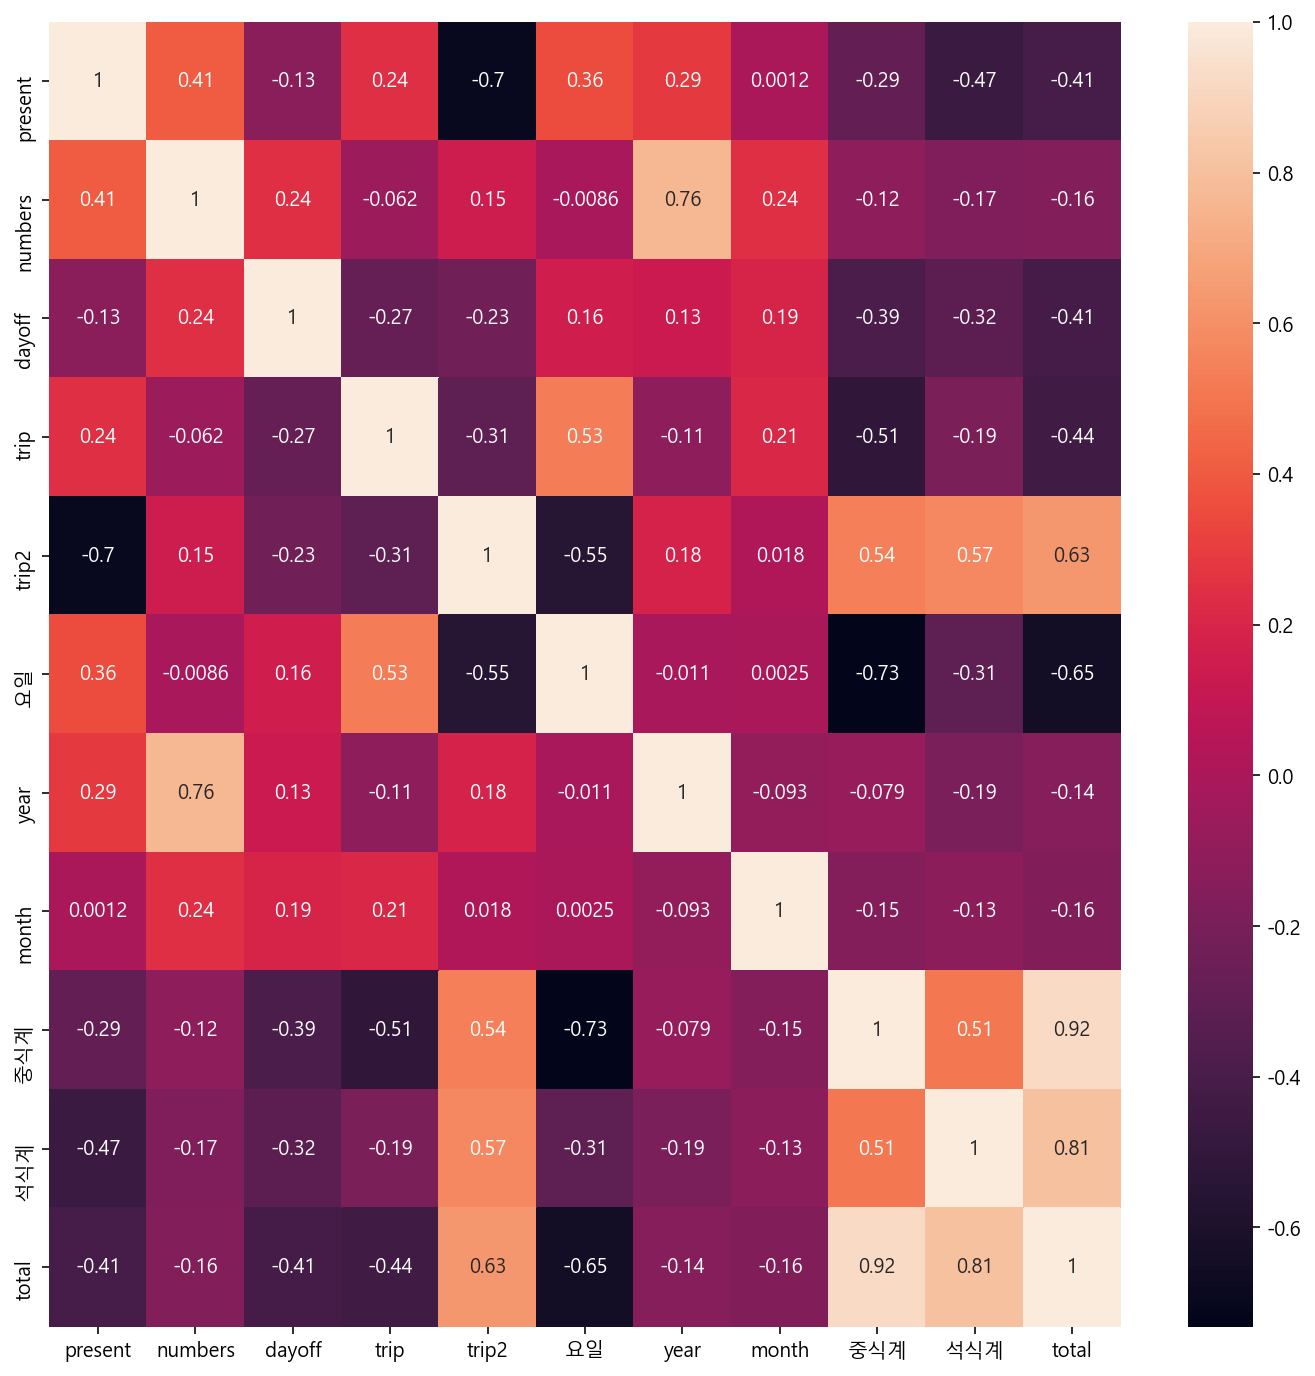

In [30]:
plt.figure(figsize=(12, 12))
sns.heatmap(train.corr(), annot=True)

## hist target

중식계의 skew:  0.09109716504038136
석식계의 skew:  -1.2190844482784289


Text(0.5, 1.0, '석식계')

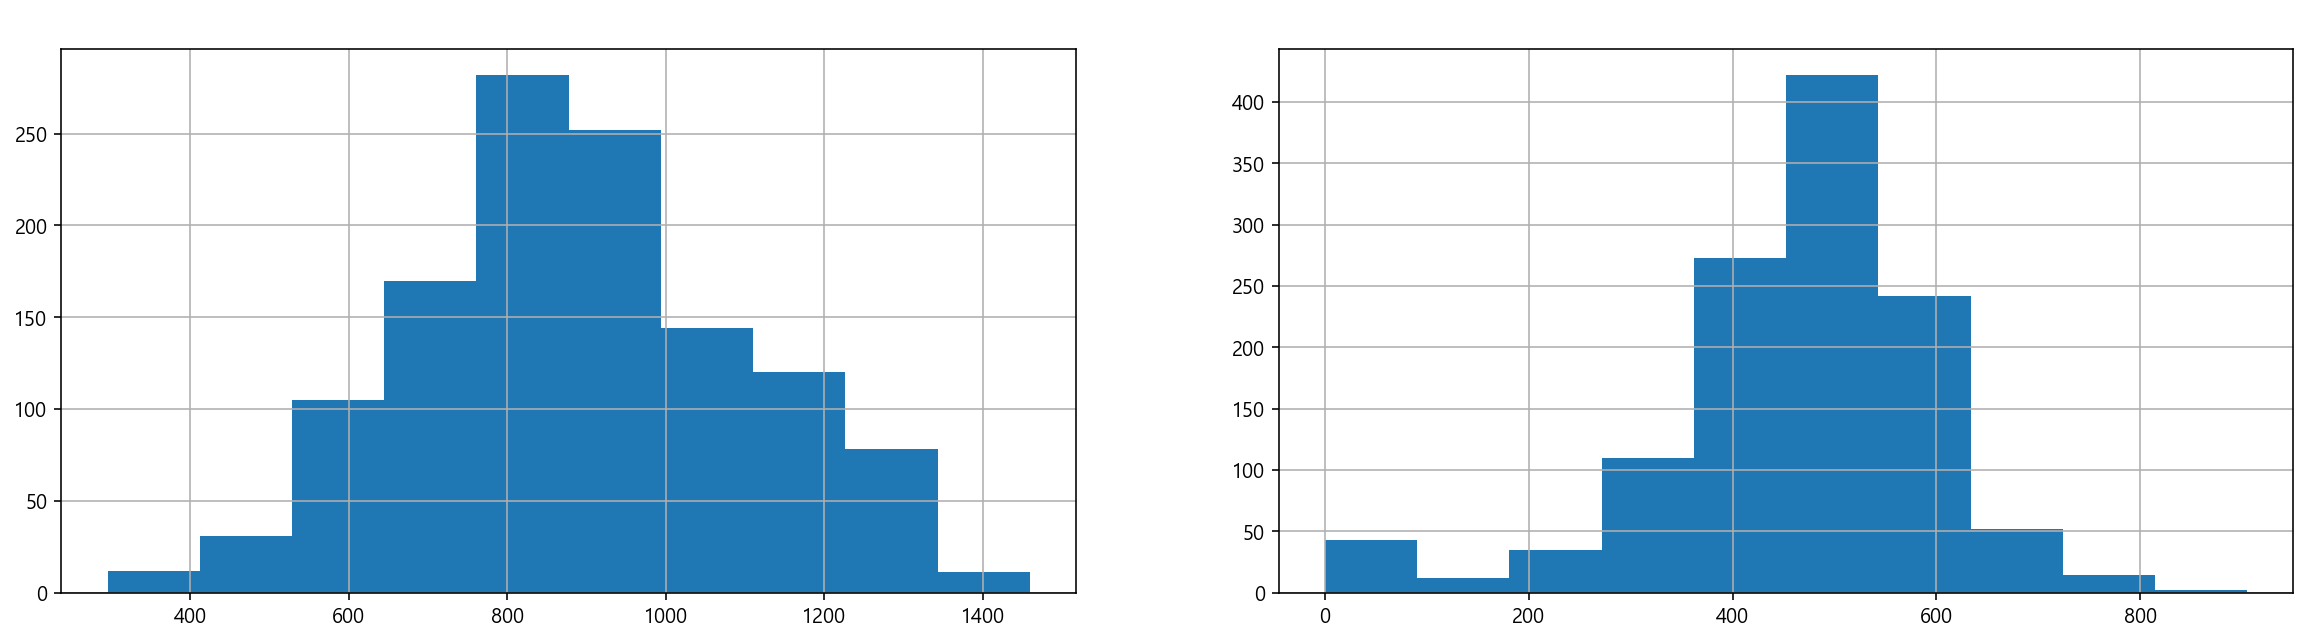

In [58]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))

train['중식계'].hist(ax=axes[0])
train['석식계'].hist(ax=axes[1])

print('중식계의 skew: ', train['중식계'].skew())
print('석식계의 skew: ', train['석식계'].skew())

axes[0].set_title('중식계', color='w', size=15)
axes[1].set_title('석식계', color='w', size=15)

분포는 정규분포 형태를 띈다

## boxplot by 요일

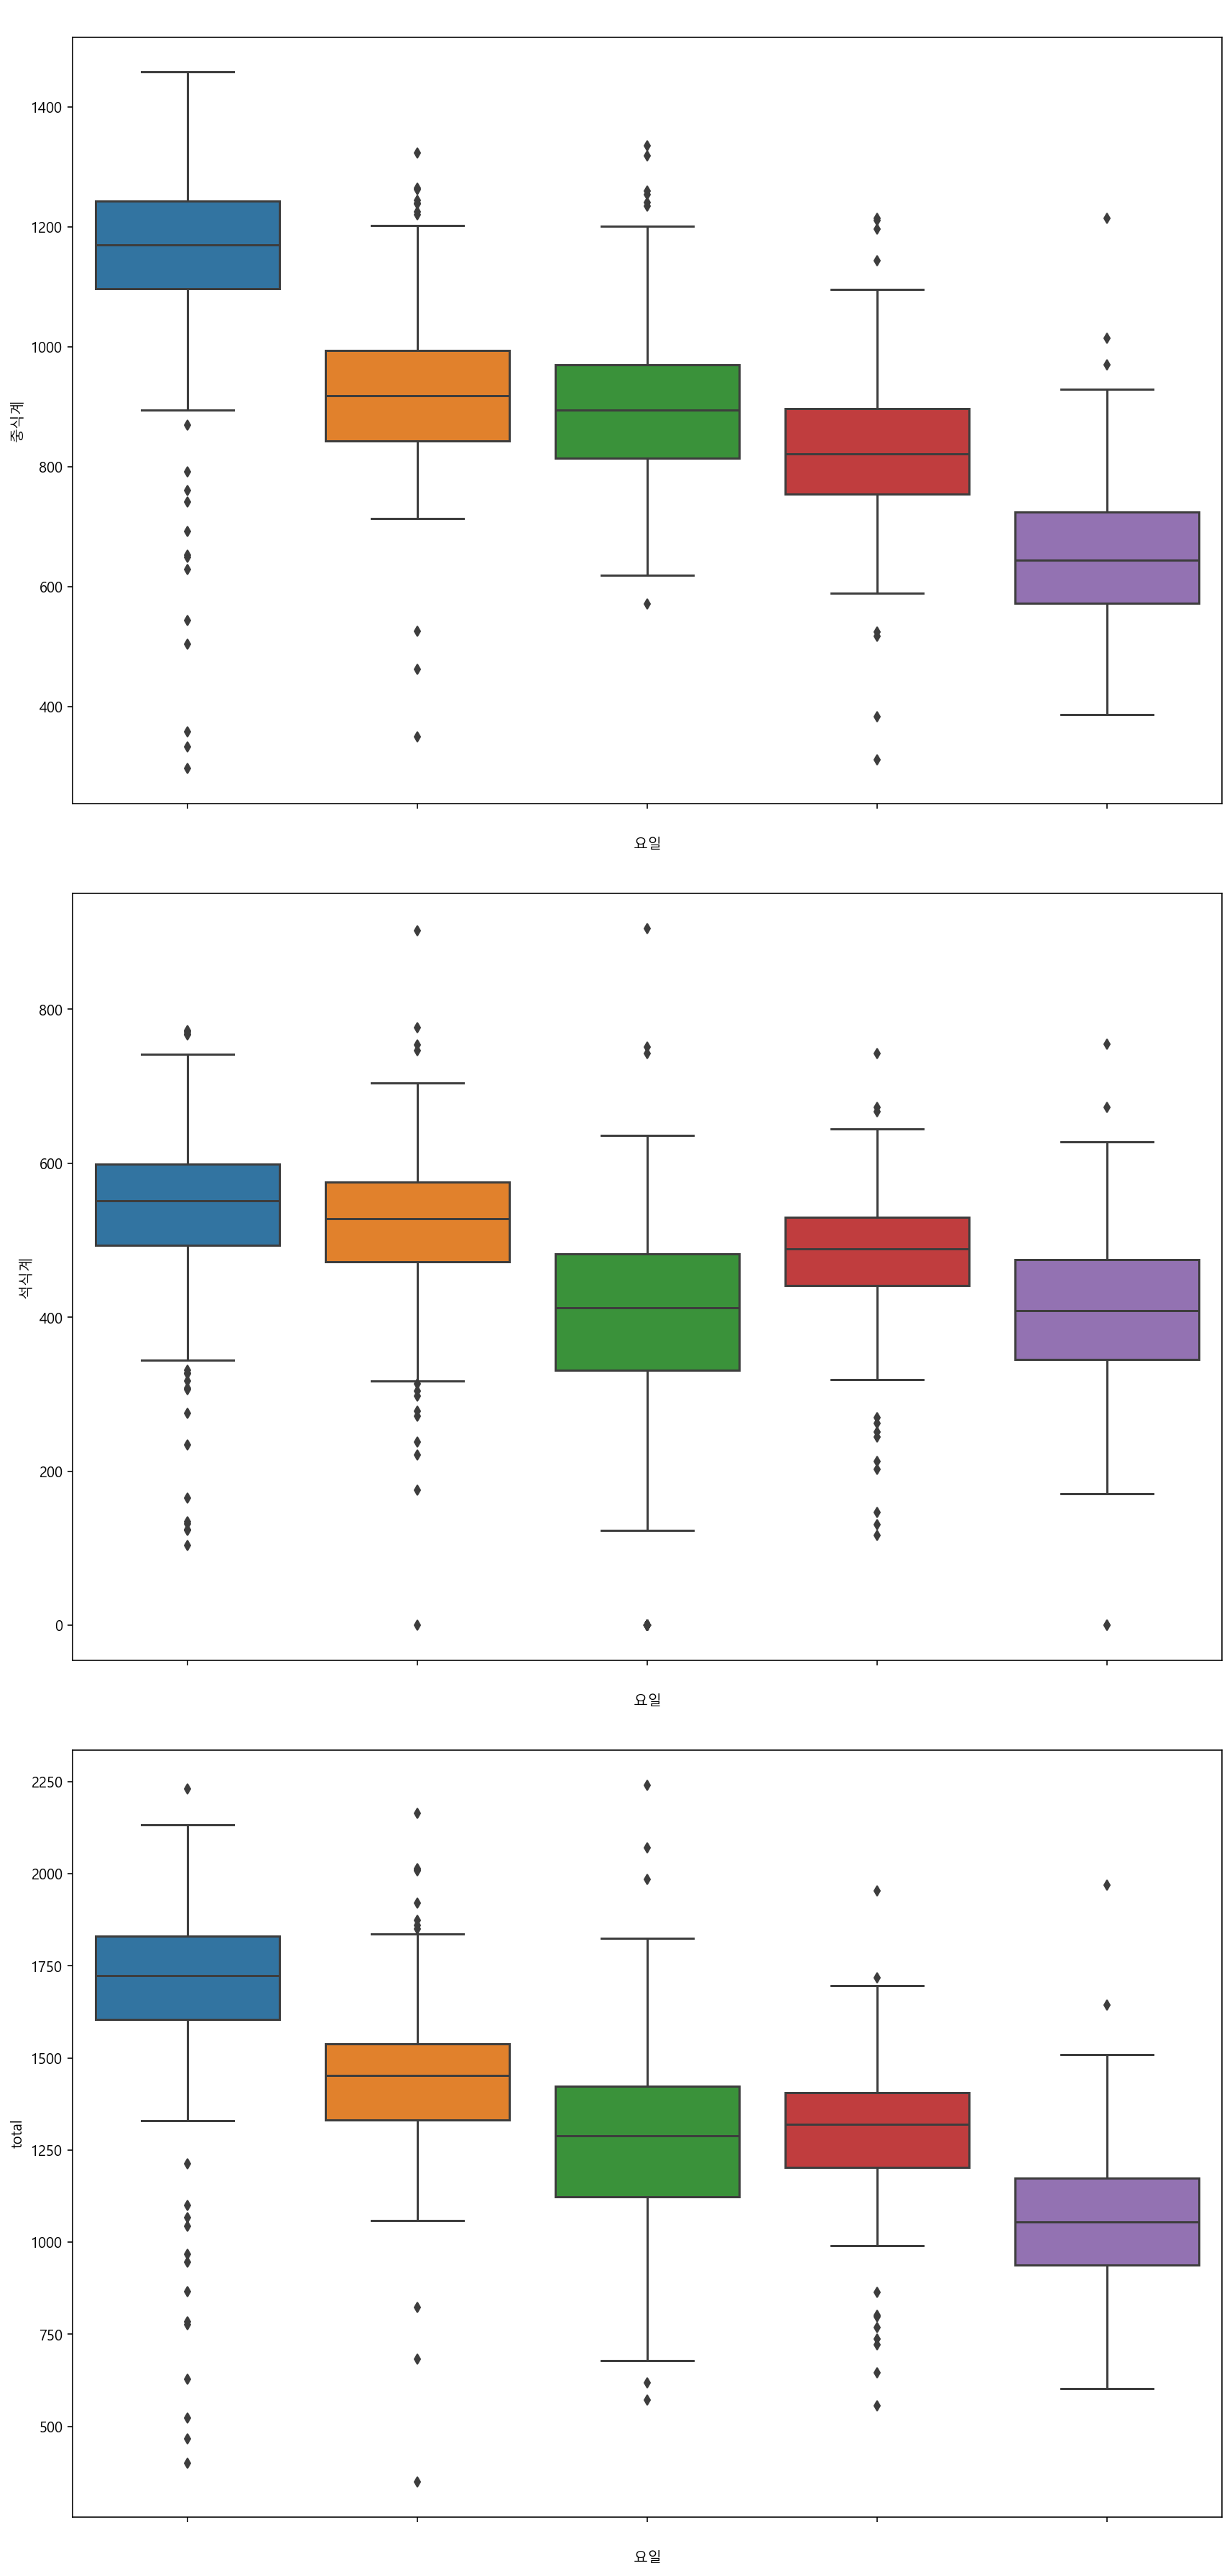

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(12, 25))

sns.boxplot(data=train, x='요일', y='중식계', ax=axes[0])
sns.boxplot(data=train, x='요일', y='석식계', ax=axes[1])
sns.boxplot(data=train, x='요일', y='total', ax=axes[2])

axes[0].set_title('중식계 by day', color='w', size=15)
axes[1].set_title('석식계 by day', color='w', size=15)
axes[2].set_title('total by day', color='w', size=15)

for i in range(3):
    labels = [item.get_text() for item in axes[i].get_xticklabels()]
    days = ['월', '화', '수', '목', '금']
    for j in range(5):
        labels[j] = days[j]
    axes[i].set_xticklabels(labels, color='w', size=12)

plt.tight_layout()

요일별로 손님 수 차이가 보인다.  
이상치가 꽤 존재한다.

## boxplot by year_month

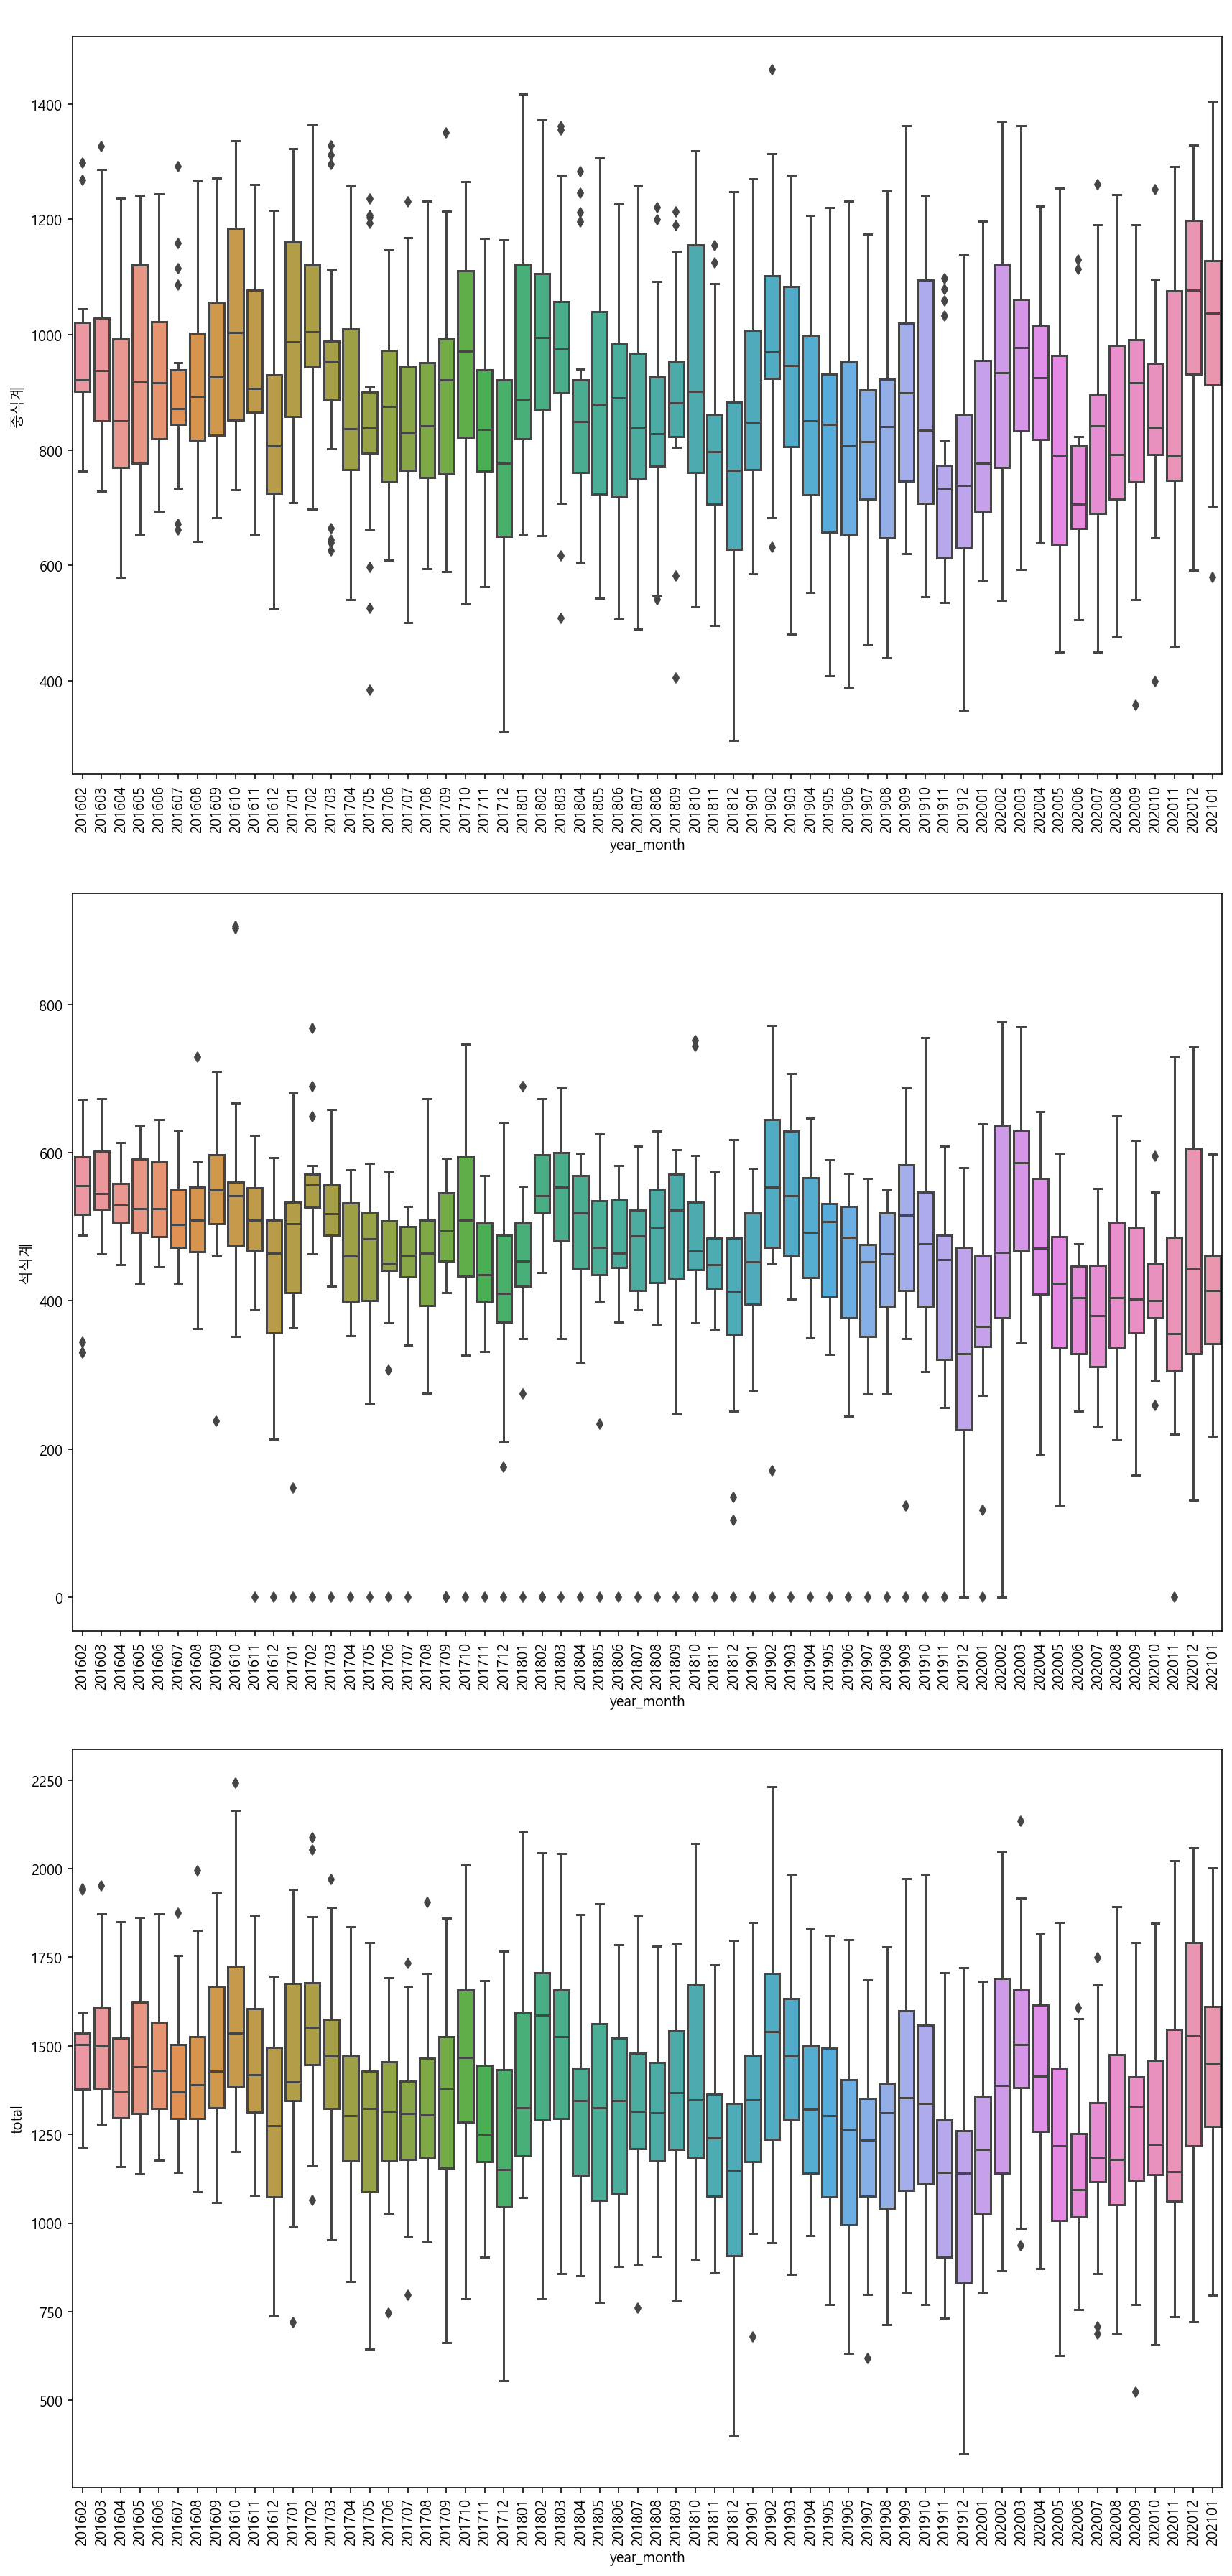

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(12, 25))

# axes[0].plot(train['year_month'], train['중식계'])
# axes[1].plot(train['year_month'], train['석식계'])
# axes[2].plot(train['year_month'], train['total'])

sns.boxplot(data=train, x='year_month', y='중식계', ax=axes[0])
sns.boxplot(data=train, x='year_month', y='석식계', ax=axes[1])
sns.boxplot(data=train, x='year_month', y='total', ax=axes[2])

axes[0].set_title('중식계 by year_month', color='w', size=15)
axes[1].set_title('석식계 by year_month', color='w', size=15)
axes[2].set_title('total by year_month', color='w', size=15)

for i in range(3):
    for item in axes[i].get_xticklabels():
        item.set_rotation(90)

# for i in range(3):
#     labels = [item.get_text() for item in axes[i].get_xticklabels()]
#     days = ['월', '화', '수', '목', '금']
#     for j in range(5):
#         labels[j] = days[j]
#     axes[i].set_xticklabels(labels, color='w', size=12)

plt.tight_layout()

## boxplot by year

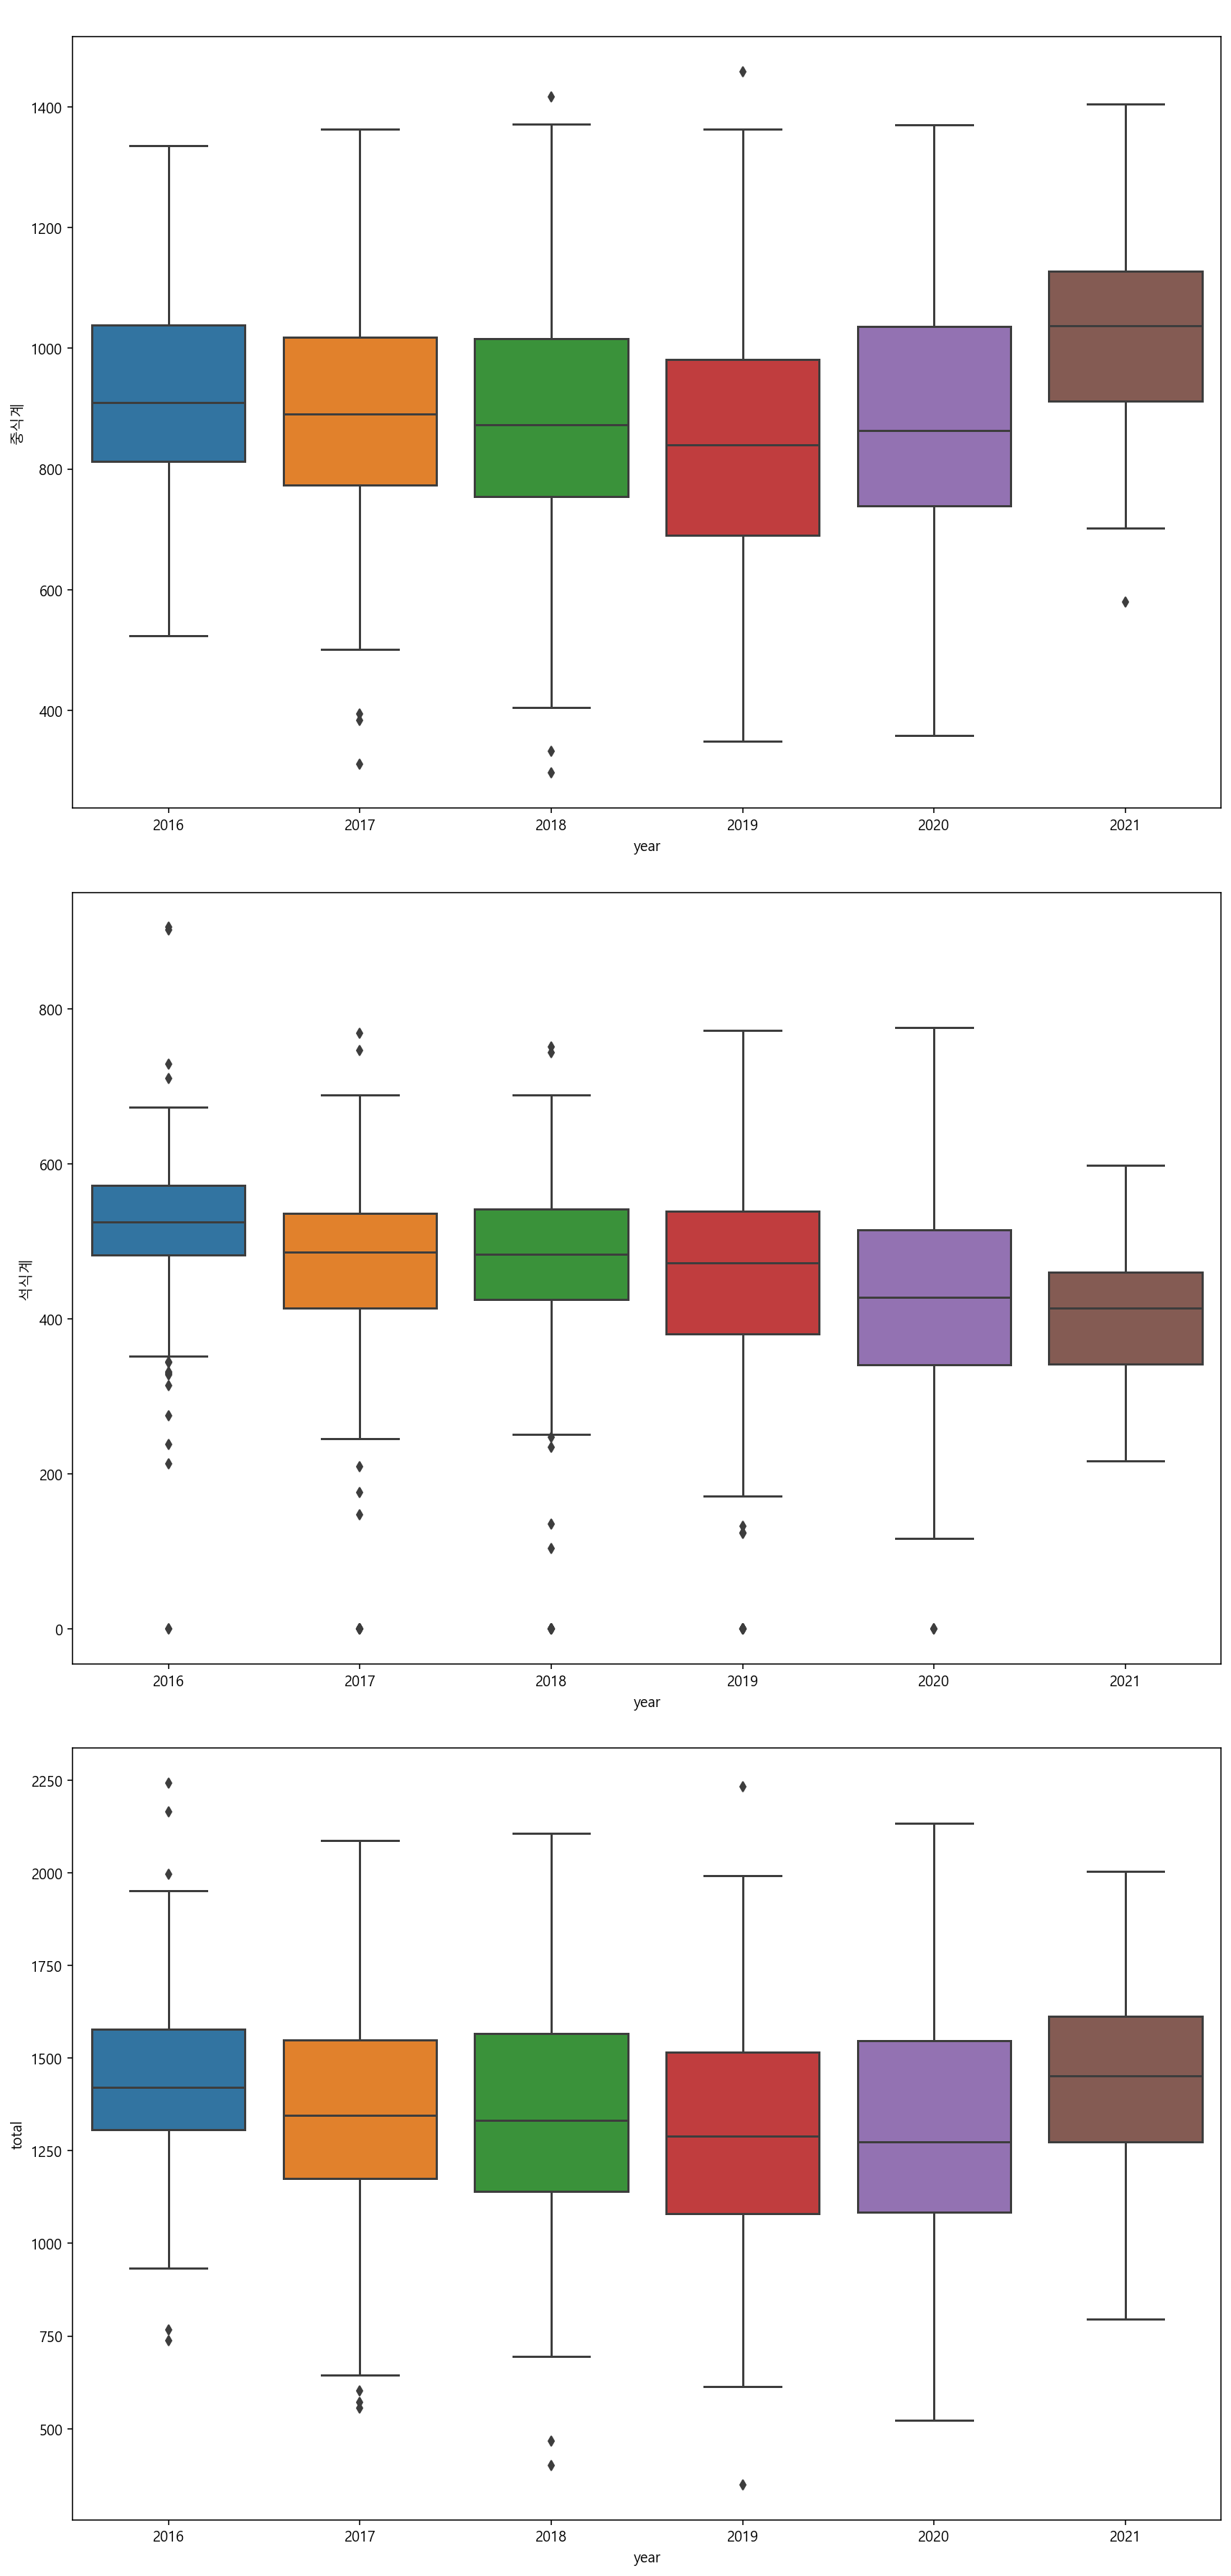

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(12, 25))

sns.boxplot(data=train, x='year', y='중식계', ax=axes[0])
sns.boxplot(data=train, x='year', y='석식계', ax=axes[1])
sns.boxplot(data=train, x='year', y='total', ax=axes[2])

axes[0].set_title('중식계 by year', color='w', size=15)
axes[1].set_title('석식계 by year', color='w', size=15)
axes[2].set_title('total by year', color='w', size=15)

# for i in range(3):
#     labels = [item.get_text() for item in axes[i].get_xticklabels()]
#     days = ['월', '화', '수', '목', '금']
#     for j in range(5):
#         labels[j] = days[j]
#     axes[i].set_xticklabels(labels, color='w', size=12)

plt.tight_layout()

## boxplot by month

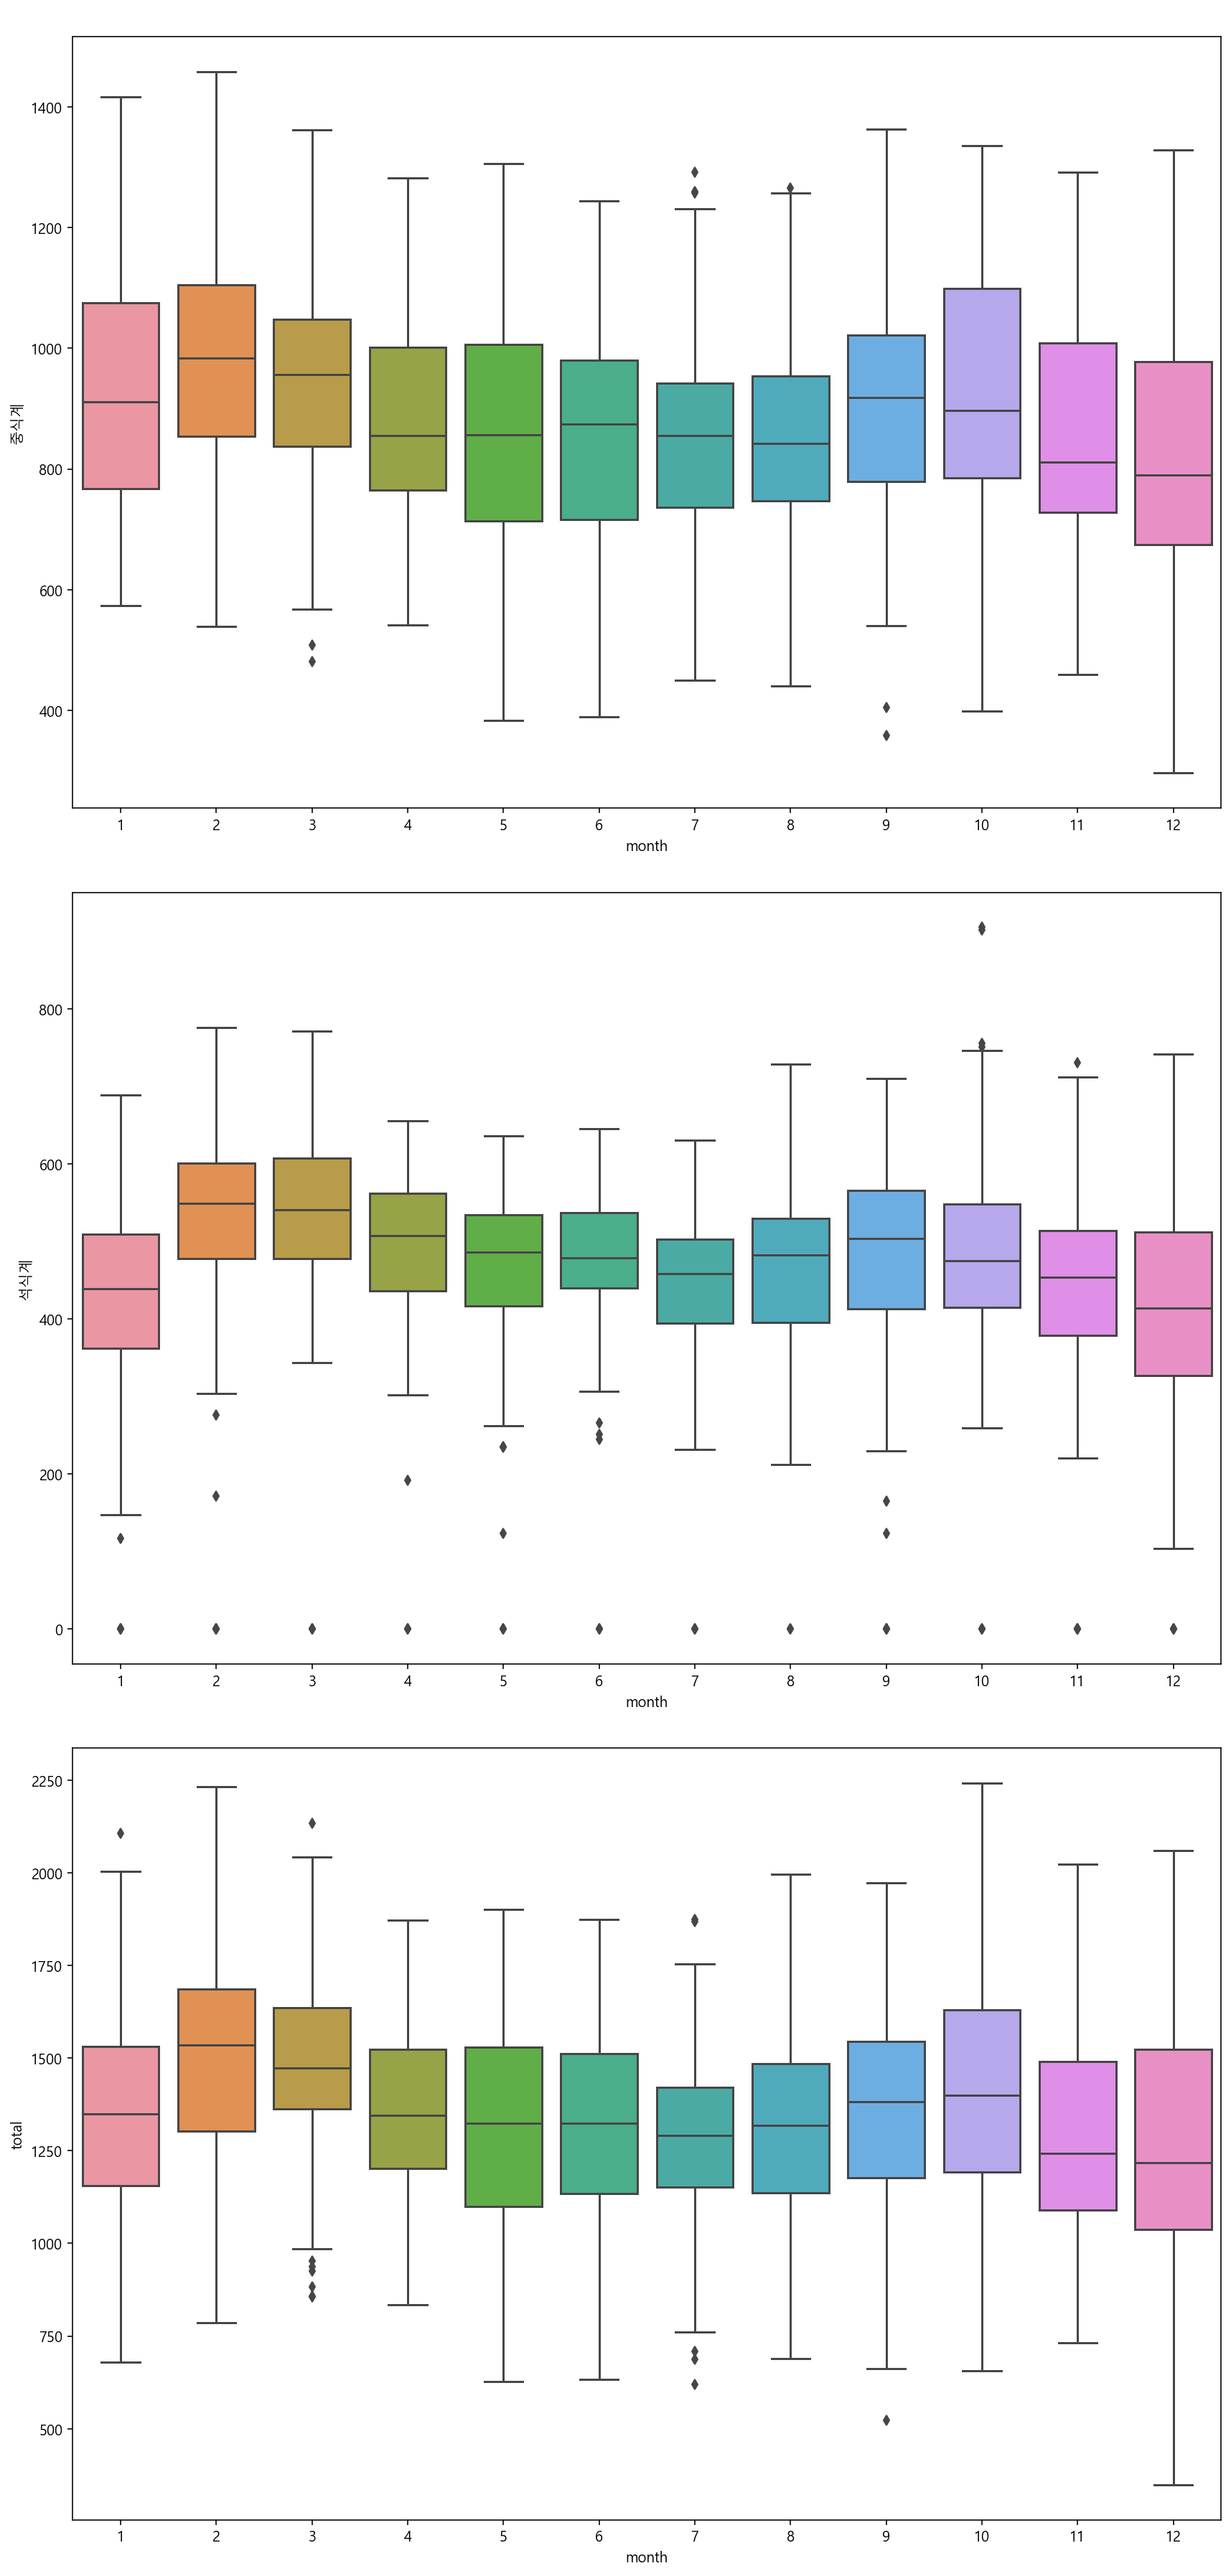

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(12, 25))

sns.boxplot(data=train, x='month', y='중식계', ax=axes[0])
sns.boxplot(data=train, x='month', y='석식계', ax=axes[1])
sns.boxplot(data=train, x='month', y='total', ax=axes[2])

axes[0].set_title('중식계 by month', color='w', size=15)
axes[1].set_title('석식계 by month', color='w', size=15)
axes[2].set_title('total by month', color='w', size=15)

# for i in range(3):
#     labels = [item.get_text() for item in axes[i].get_xticklabels()]
#     days = ['월', '화', '수', '목', '금']
#     for j in range(5):
#         labels[j] = days[j]
#     axes[i].set_xticklabels(labels, color='w', size=12)

plt.tight_layout()

## boxplot by day

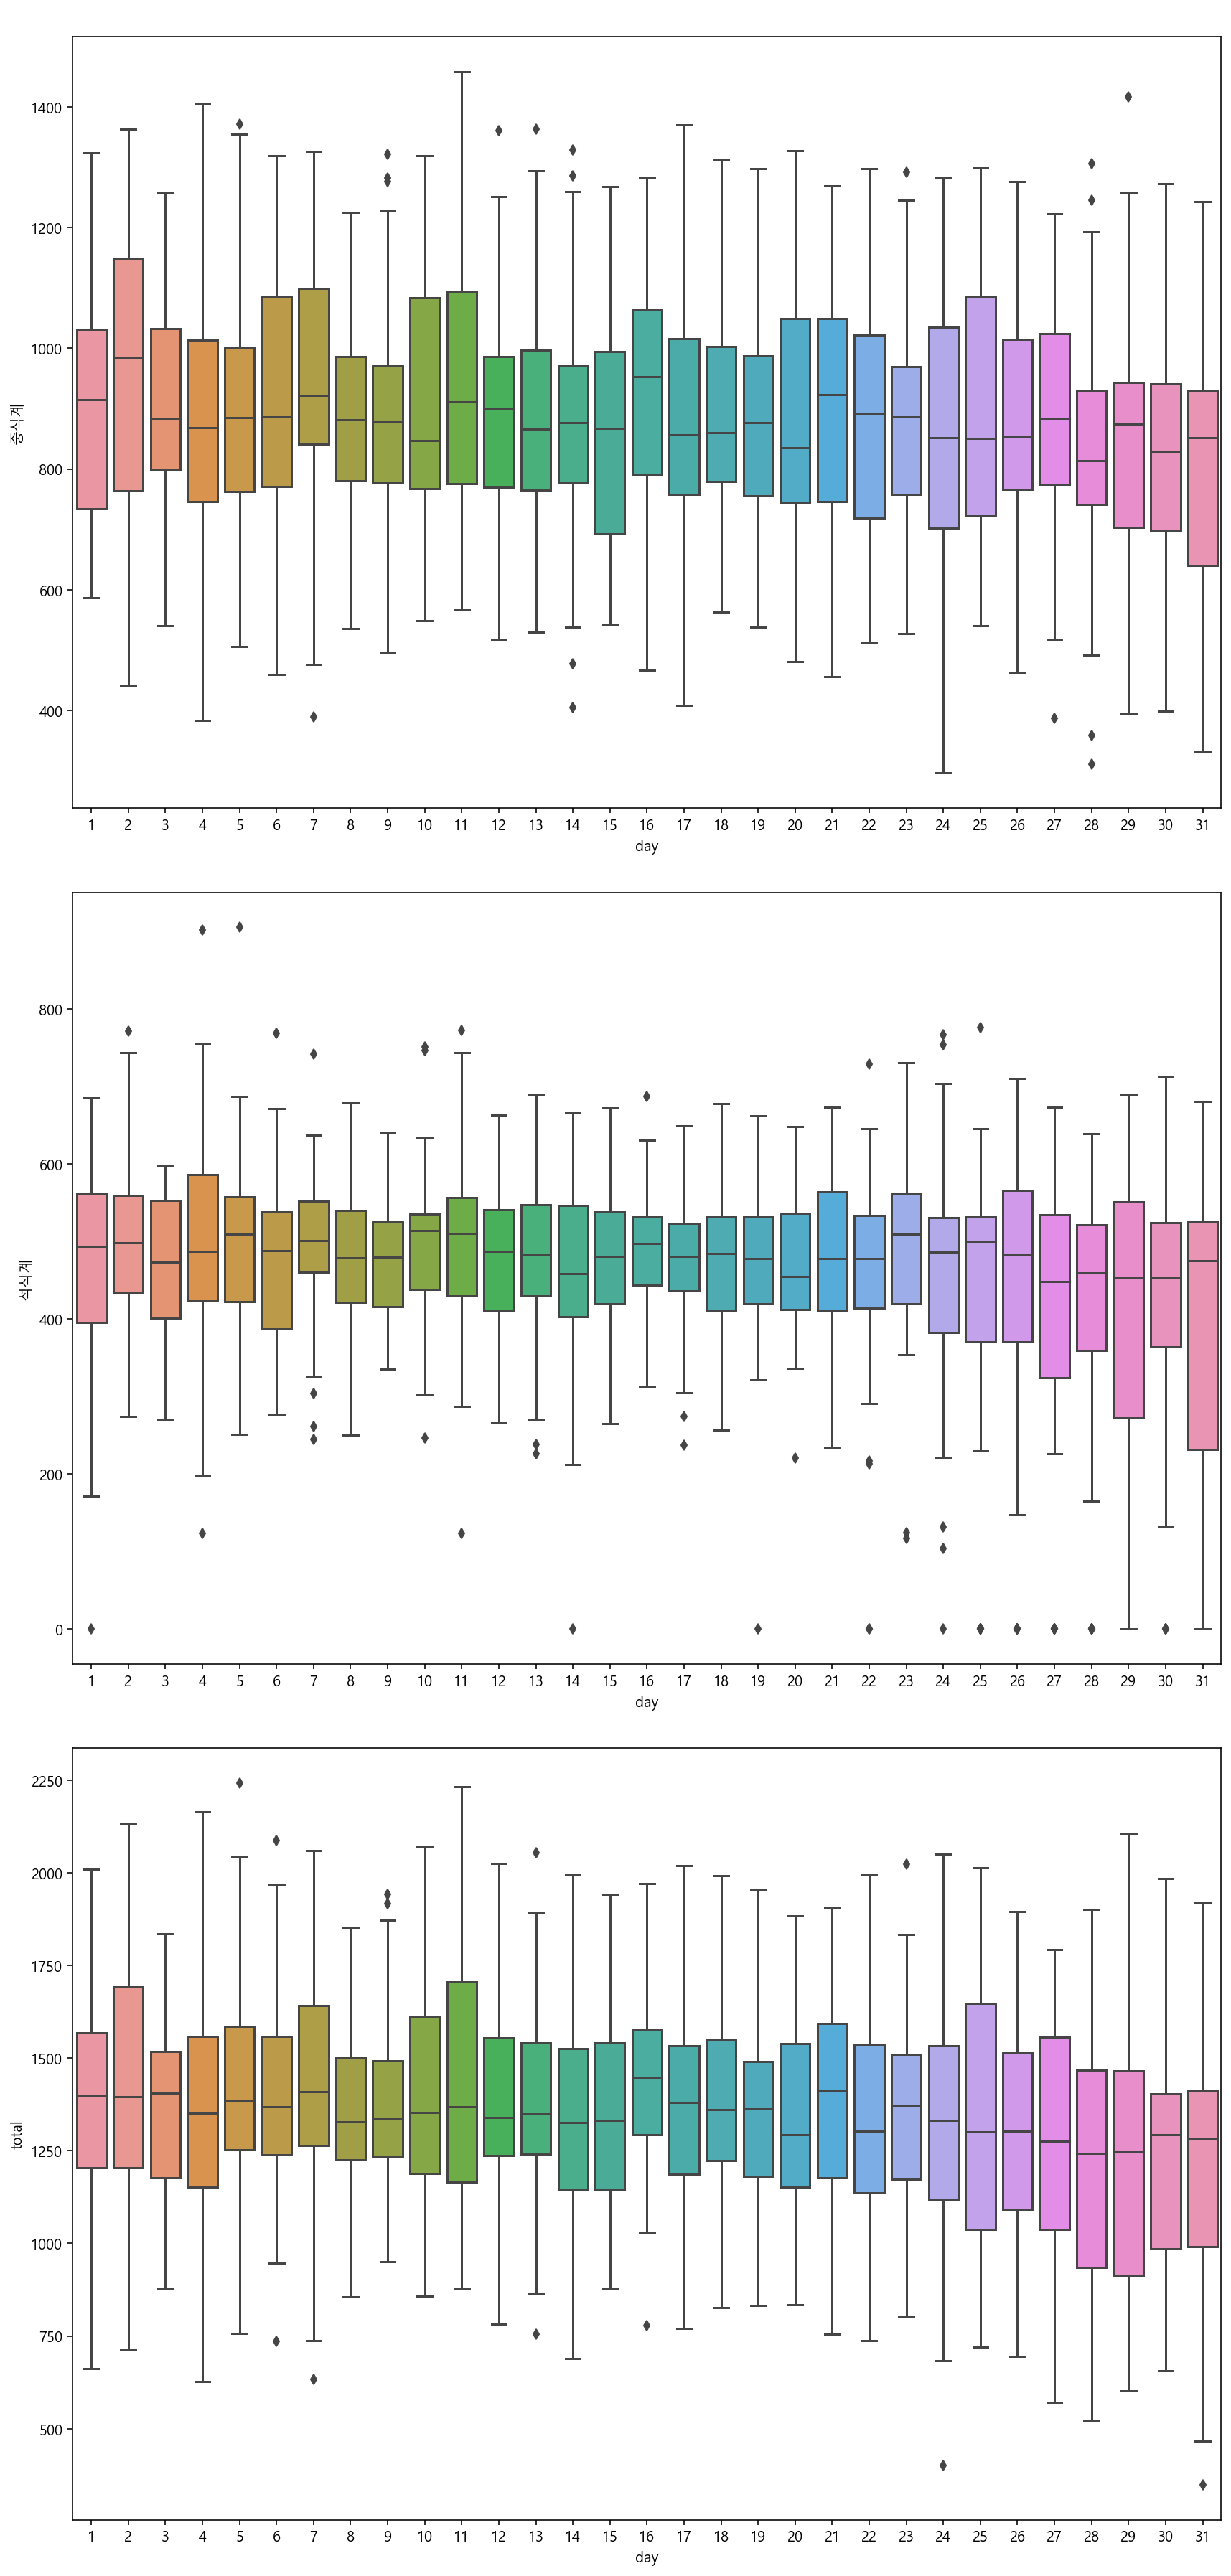

In [51]:
fig, axes = plt.subplots(3, 1, figsize=(12, 25))

sns.boxplot(data=train, x='day', y='중식계', ax=axes[0])
sns.boxplot(data=train, x='day', y='석식계', ax=axes[1])
sns.boxplot(data=train, x='day', y='total', ax=axes[2])

axes[0].set_title('중식계 by day', color='w', size=15)
axes[1].set_title('석식계 by day', color='w', size=15)
axes[2].set_title('total by day', color='w', size=15)

# for i in range(3):
#     labels = [item.get_text() for item in axes[i].get_xticklabels()]
#     days = ['월', '화', '수', '목', '금']
#     for j in range(5):
#         labels[j] = days[j]
#     axes[i].set_xticklabels(labels, color='w', size=12)

plt.tight_layout()

# Modeling

## data load

In [32]:
# train = pd.read_csv('data/' + listdir[2])
train = pd.read_csv('train.csv')
# test = pd.read_csv('data/' + listdir[1])
test = pd.read_csv('test.csv')
sub = pd.read_csv('data/' + listdir[0])

## preprocessing

In [102]:
total_lunch = pd.concat([train, test])
total_lunch.drop(['석식계', 'total', 'dinner_bob', 'dinner_soup', 'dinner_main'], axis=1, inplace=True)
total_lunch.head()

,present,numbers,dayoff,trip,trip2,요일,year,month,year_month,lunch_bob,lunch_soup,lunch_main,중식계
0,2163,2601,50,150,238,0,2016,2,201602,밥,오징어찌개,쇠불고기,1039.0
1,2059,2601,50,173,319,1,2016,2,201602,밥,김치찌개,가자미튀김,867.0
2,2254,2601,56,180,111,2,2016,2,201602,카레덮밥,팽이장국,치킨핑거,1017.0
3,1922,2601,104,220,355,3,2016,2,201602,밥,쇠고기무국,주꾸미볶음,978.0
4,2108,2601,278,181,34,4,2016,2,201602,밥,떡국,돈육씨앗강정,925.0


In [106]:
object_columns = total_lunch.dtypes[total_lunch.dtypes=='object'].index.tolist()

for column in object_columns:
    total_lunch[column] = pd.factorize(total_lunch[column])[0]

In [107]:
train_lunch = total_lunch[~total_lunch['중식계'].isnull()]
test_lunch = total_lunch[total_lunch['중식계'].isnull()]

In [134]:
total_dinner = pd.concat([train, test])
total_dinner.drop(['중식계', 'total', 'lunch_bob', 'lunch_soup', 'lunch_main'], axis=1, inplace=True)
total_dinner = total_dinner[~total_dinner['dinner_main'].str.contains('None')]
total_dinner.head()

,present,numbers,dayoff,trip,trip2,요일,year,month,year_month,dinner_bob,dinner_soup,dinner_main,석식계
0,2163,2601,50,150,238,0,2016,2,201602,밥,육개장,자반고등어구이,331.0
1,2059,2601,50,173,319,1,2016,2,201602,어묵국,유산슬,아삭고추무침,560.0
2,2254,2601,56,180,111,2,2016,2,201602,밥,청국장찌개,황태양념구이,573.0
3,1922,2601,104,220,355,3,2016,2,201602,우동,멕시칸샐러드,군고구마,525.0
4,2108,2601,278,181,34,4,2016,2,201602,밥,차돌박이찌개,닭갈비,330.0


In [135]:
object_columns = total_dinner.dtypes[total_dinner.dtypes=='object'].index.tolist()

for column in object_columns:
    total_dinner[column] = pd.factorize(total_dinner[column])[0]

In [136]:
train_dinner = total_dinner[~total_dinner['석식계'].isnull()]
test_dinner = total_dinner[total_dinner['석식계'].isnull()]

In [137]:
ftr_lunch = train_lunch.drop(['중식계'], axis=1)
target_lunch = train_lunch['중식계']
ftr_dinner = train_dinner.drop(['석식계'], axis=1)
target_dinner = train_dinner['석식계']

## test

In [138]:
def total_test(models):
    for model in models:
        model.fit(train_x_lunch, train_y_lunch)
        pred_lunch = model.predict(valid_x_lunch)
        result_lunch = mean_absolute_error(valid_y_lunch, pred_lunch)
    
        model.fit(train_x_dinner, train_y_dinner)
        pred_dinner = model.predict(valid_x_dinner)
        result_dinner = mean_absolute_error(valid_y_dinner, pred_dinner)
    
        print('model: ', model.__class__)
        print('중식계: ', result_lunch)
        print('석식계: ', result_dinner)
        print('total: ', (result_lunch + result_dinner) / 2.0)

In [139]:
train_x_lunch, valid_x_lunch, train_y_lunch, valid_y_lunch = train_test_split(ftr_lunch, target_lunch, test_size=0.25)
train_x_dinner, valid_x_dinner, train_y_dinner, valid_y_dinner = train_test_split(ftr_dinner, target_dinner, test_size=0.25)

In [140]:
lr_reg = LinearRegression()
rf_reg = RandomForestRegressor()
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)

models = [lr_reg, rf_reg, xgb_reg]

total_test(models)

model:  <class 'sklearn.linear_model._base.LinearRegression'>
중식계:  82.84964577237045
석식계:  54.62093422840576
total:  68.7352900003881
model:  <class 'sklearn.ensemble._forest.RandomForestRegressor'>
중식계:  72.04145695364237
석식계:  47.265017182130585
total:  59.65323706788648
model:  <class 'xgboost.sklearn.XGBRegressor'>
중식계:  69.97919115483366
석식계:  45.292568613163795
total:  57.635879883998726


[0]	validation_0-mae:847.38184	validation_1-mae:840.34528
[100]	validation_0-mae:39.64646	validation_1-mae:68.55057
[200]	validation_0-mae:23.53063	validation_1-mae:68.36104
[266]	validation_0-mae:17.02039	validation_1-mae:68.85905


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1152x2304 with 0 Axes>

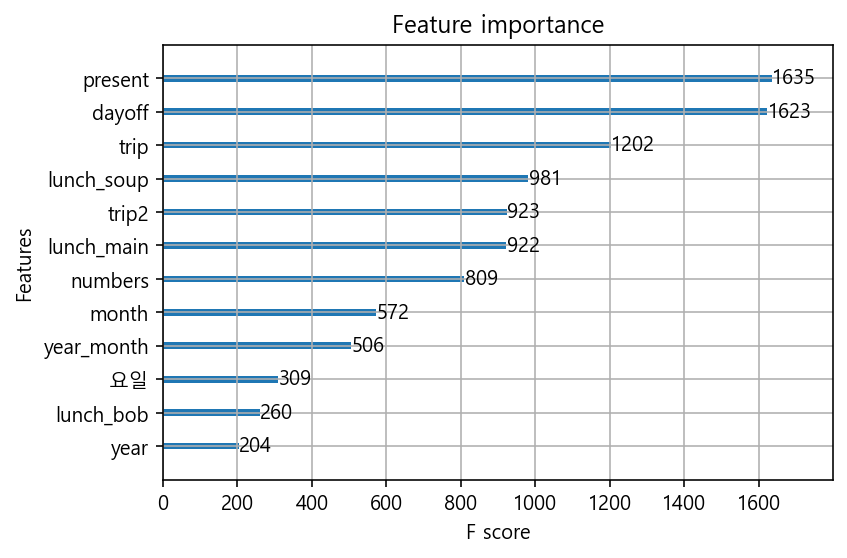

In [145]:
plt.figure(figsize=(16, 32))
xgb_reg.fit(train_x_lunch, train_y_lunch, eval_set=[(train_x_lunch, train_y_lunch), (valid_x_lunch, valid_y_lunch)]
        , eval_metric='mae', verbose= 100, 
        early_stopping_rounds= 100)
plot_importance(xgb_reg)

In [146]:
test_lunch['중식계'] = xgb_reg.predict(test_lunch.drop(['중식계'], axis=1))

[0]	validation_0-mae:453.44559	validation_1-mae:455.20236
[100]	validation_0-mae:25.66102	validation_1-mae:47.80519
[200]	validation_0-mae:15.06486	validation_1-mae:45.96868
[300]	validation_0-mae:9.28604	validation_1-mae:45.63099
[360]	validation_0-mae:7.15210	validation_1-mae:45.62169


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1152x2304 with 0 Axes>

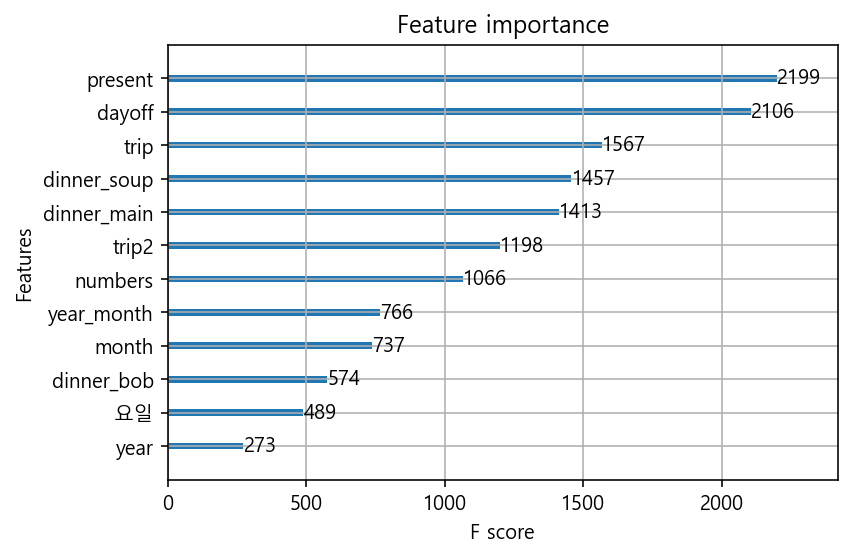

In [147]:
plt.figure(figsize=(16, 32))
xgb_reg.fit(train_x_dinner, train_y_dinner, eval_set=[(train_x_dinner, train_y_dinner), (valid_x_dinner, valid_y_dinner)]
        , eval_metric='mae', verbose= 100, 
        early_stopping_rounds= 100)
plot_importance(xgb_reg)

In [148]:
test_dinner['석식계'] = xgb_reg.predict(test_dinner.drop(['석식계'], axis=1))

In [149]:
sub['중식계'] = test_lunch['중식계']
sub['석식계'] = test_dinner['석식계']

In [150]:
sub.to_csv('sub/12_19.csv', index=False)

In [97]:
lgbm_reg = LGBMRegressor(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

lgbm_reg.fit(train_x_lunch, train_y_lunch, eval_set=[(train_x_lunch, train_y_lunch), (valid_x_lunch, valid_y_lunch)]
        , eval_metric= 'mae', verbose= 100, 
        early_stopping_rounds= 100)

[100]	training's l1: 60.8454	training's l2: 6579.94	valid_1's l1: 80.2701	valid_1's l2: 13025.8
[200]	training's l1: 43.6627	training's l2: 3352.94	valid_1's l1: 71.3662	valid_1's l2: 10476.1
[300]	training's l1: 36.6769	training's l2: 2329.28	valid_1's l1: 69.8692	valid_1's l2: 9889.78
[400]	training's l1: 31.8441	training's l2: 1733.95	valid_1's l1: 69.4452	valid_1's l2: 9660.64
[500]	training's l1: 28.1198	training's l2: 1337.57	valid_1's l1: 69.4417	valid_1's l2: 9550.07
[600]	training's l1: 24.398	training's l2: 1007.77	valid_1's l1: 69.2728	valid_1's l2: 9416.42
[700]	training's l1: 21.4513	training's l2: 775.66	valid_1's l1: 69.1459	valid_1's l2: 9350.89
[800]	training's l1: 19.0673	training's l2: 614.055	valid_1's l1: 69.2651	valid_1's l2: 9367.67


LGBMRegressor(learning_rate=0.02, max_depth=12, n_estimators=1000,
              num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

In [82]:
model.fit(train_x_lunch, train_y_lunch)
pred_lunch = model.predict(valid_x_lunch)
print(mean_absolute_error(valid_y_lunch, pred_lunch))

90.41375225474445


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

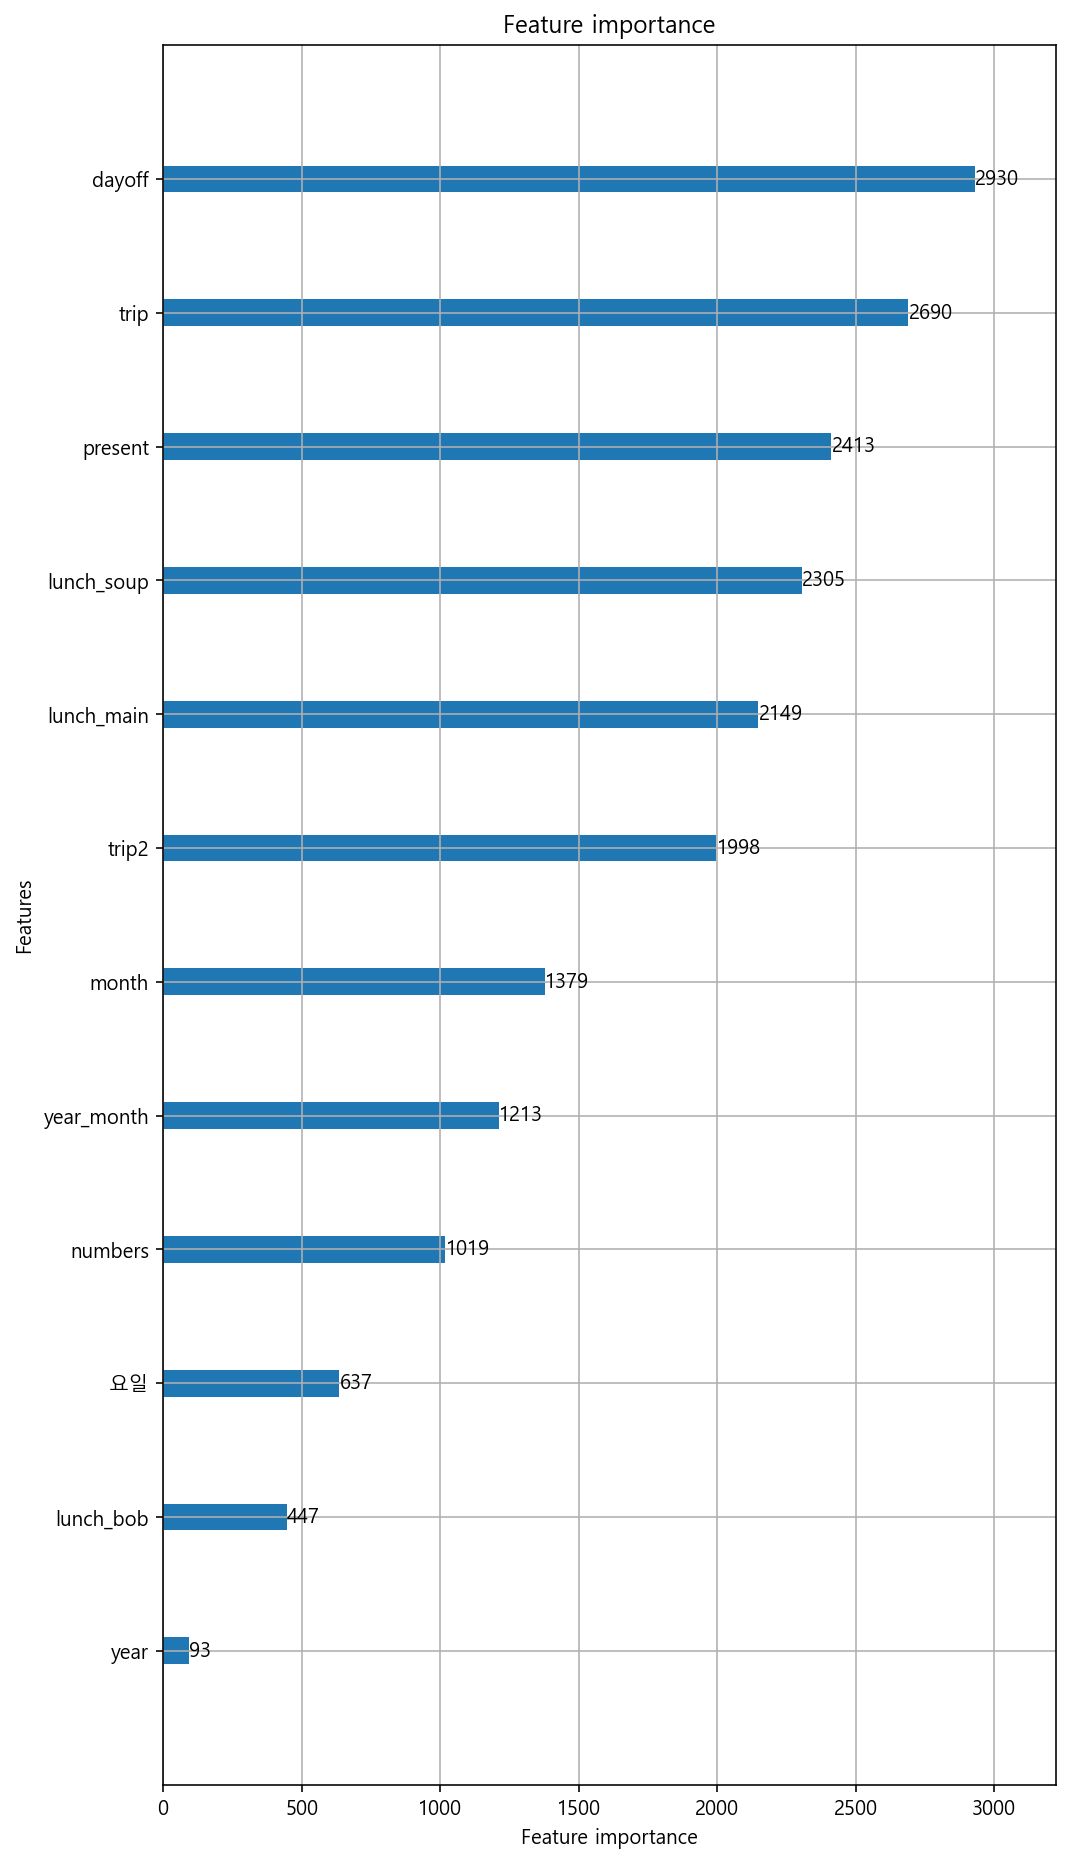

In [79]:
from lightgbm import plot_importance

plot_importance(lgbm_reg, figsize=(8, 16))

## sub

In [161]:
def make_sub(model, sub):
    temp = sub.copy()
    
    model.fit(ftr_lunch, target_lunch)
    temp['중식계'] = model.predict(test_lunch.drop(['중식계'], axis=1))
    
    model.fit(ftr_dinner, target_dinner)
    temp['석식계'] = model.predict(test_dinner.drop(['석식계'], axis=1))
    
    return temp

### xgb

#### simple
- 메뉴, represent, year_month 추가
public: 88.3866783333
private: 130.6945972857
- 기본적인 것들
public: 81.9395816667  
private: 126.1207585714

오히려 점수가 안좋아졌는데 왜 그럴까

In [162]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
sub = make_sub(xgb_reg, sub)
sub.to_csv('sub/xgb.csv', index=False)

In [624]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
xgb_reg.fit(X_features_lunch, y_target_lunch)
sub['중식계'] = xgb_reg.predict(test_lunch)

In [625]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
xgb_reg.fit(X_features_dinner, y_target_dinner)
sub['석식계'] = xgb_reg.predict(test_dinner)

In [626]:
sub.to_csv('sub/xgb.csv', index=False)

#### tuning
public: 81.0859823333  
private: 127.6448167143	

In [100]:
params = {'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [0.5, 0.7],
              'n_estimators': [1000]}

xgb_grid = GridSearchCV(estimator = xgb_reg,
                        param_grid=params,
                        cv = 3,
                        n_jobs = -1,
                        verbose= False, 
                        refit=True, 
                        scoring='neg_mean_absolute_error')

xgb_grid.fit(X_features_lunch, y_target_lunch)

best_params_lunch = xgb_grid.best_params_

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

-80.57018671505774
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1000, 'subsample': 0.7}


In [101]:
params = {'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [0.5, 0.7],
              'n_estimators': [1000]}

xgb_grid = GridSearchCV(estimator = xgb_reg,
                        param_grid=params,
                        cv = 3,
                        n_jobs = -1,
                        verbose= False, 
                        refit=True, 
                        scoring='neg_mean_absolute_error')

xgb_grid.fit(X_features_dinner, y_target_dinner)

best_params_dinner = xgb_grid.best_params_

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

-68.3156457767185
{'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1000, 'subsample': 0.8}


In [105]:
xgb_reg_lunch = XGBRegressor(**best_params_lunch)
xgb_reg_lunch.fit(X_features_lunch, y_target_lunch)
sub['중식계'] = xgb_reg_lunch.predict(test_lunch)

In [106]:
xgb_reg_dinner = XGBRegressor(**best_params_dinner)
xgb_reg_dinner.fit(X_features_dinner, y_target_dinner)
sub['석식계'] = xgb_reg_dinner.predict(test_dinner)

In [107]:
sub.to_csv('sub/tuning_XGB.csv', index=False)

### voting
public: 87.5280034245  
private: 128.8007022044

In [183]:
pred_reg_1, pred_reg_2 = make_sub(lr_reg)
pred_rf_1, pred_rf_2 = make_sub(rf_reg)
pred_xgb_1, pred_xgb_2 = make_sub(xgb_reg)

In [184]:
pred_1 = (pred_reg_1 + pred_rf_1 + pred_xgb_1) / 3
pred_2 = (pred_reg_2 + pred_rf_2 + pred_xgb_2) / 3

In [185]:
sub['중식계'] = pred_1
sub['석식계'] = pred_2

In [186]:
sub.to_csv('sub/voting(lr+rf+xgb).csv', index=False)